# Machine Failures Detection with Autoencoder LSTM
#### Author: Alfian Rahman
This notebook will discuss about the detection of machine failures anomaly using autoencoder LSTM. The data comes from NASA Acoustics and Vibration Database (https://ti.arc.nasa.gov/c/3/) Set No. 2. The data in this notebook has been pre-processed by taking the mean absolute. In this case, the data doesn't have any labels (unsupervised learning case). We will experiment to use the autoencoder LSTM to label the anomalies. You can see the the details of autoencoder LSTM process in the README file.        

#### Reference  
J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository (https://ti.arc.nasa.gov/c/3/), NASA Ames Research Center, Moffett Field, CA

## Import Libraries 
These are the details of the names and usages of the libraries that will be used in this notebook:
<table>
    <tr>
        <th style='text-align:center'>Library Name</th>
        <th style='text-align:center'>Function</th>
    </tr>
    <tr>
        <td style='text-align:left'>Matplotlib</td>
        <td style='text-align:left'>Data visualization</td>
    </tr> 
    <tr>
        <td style='text-align:left'>Numpy</td>
        <td style='text-align:left'>Data (matrix and vector) manipulation</td>
    </tr>
    <tr>
        <td style='text-align:left'>Pandas</td>
        <td style='text-align:left'>Data (dataframe and series) manipulation</td>
    </tr>  
    <tr>
        <td style='text-align:left'>Seaborn</td>
        <td style='text-align:left'>Data visualization</td>
    </tr>  
    <tr>
        <td style='text-align:left'>Statsmodels</td>
        <td style='text-align:left'>Time-series analysis</td>
    </tr>  
    <tr>
        <td style='text-align:left'>Tensorflow</td>
        <td style='text-align:left'>Build LSTM model</td>
    </tr>  
    <tr>
        <td style='text-align:left'>Scikit-learn</td>
        <td style='text-align:left'>Data normalization</td>
    </tr> 
</table>


In [25]:
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf 
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler

# Set the seet for both Numpy and Tensorflow 
np.random.seed(2)
tf.random.set_seed(2)

sns.set() # Set the Matplotlib to use Seaborn style
mpl.rcParams['figure.figsize'] = 18, 10 # Set the default parameter configuration for Matplotlib

## Load Data
Because the data is in CSV format, we could use Pandas library to import the data. 

In [26]:
PATH = 'dataset/nasa_bearing_dataset.csv' # Directory to the file
df = pd.read_csv(PATH)

## Data Cleaning
We will look at the column names and data types. We also need to check if there is any None, NaN, etc. values.

In [27]:
df.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


### Renaming the Columns 
The first column name ("Unnamed: 0") needs to be renamed.  

In [28]:
# Rename the columns
df = df.rename(columns={'Unnamed: 0' : 'Observation Time'})

In [29]:
# Check the data types
df.dtypes

Observation Time     object
Bearing 1           float64
Bearing 2           float64
Bearing 3           float64
Bearing 4           float64
dtype: object

### Parsing the Datetime and Setting the Index 
The first column which is supposed in datetime format needs to be converted and set as the DataFrame index. Making the datetime column as index will ease the further analysis process.

In [30]:
# Parse the datetime 
df['Observation Time'] = pd.to_datetime(df['Observation Time'], format='%Y-%m-%d %H:%M:%S')

# Set the DataFrame index
df = df.set_index('Observation Time')
df = df.sort_index()

In [31]:
# Check if there is any None/NaN/etc-type data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 982 entries, 2004-02-12 10:52:39 to 2004-02-19 06:22:39
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bearing 1  982 non-null    float64
 1   Bearing 2  982 non-null    float64
 2   Bearing 3  982 non-null    float64
 3   Bearing 4  982 non-null    float64
dtypes: float64(4)
memory usage: 38.4 KB


The data is clean enough to be processed.

# Exploratory Data Analysis
In this part, we will plot the data to get more understanding about the data behaviour and check the stationarity of the data.

### FFT (Fast Fourier Transform)
To know the amplitude of each frequency, we use the FFT.

In [32]:
data_fft = np.fft.fft(df)

### Plotting the data
Here we will use line chart to know the general trend of the data and box plot to know the distribution of the data. 

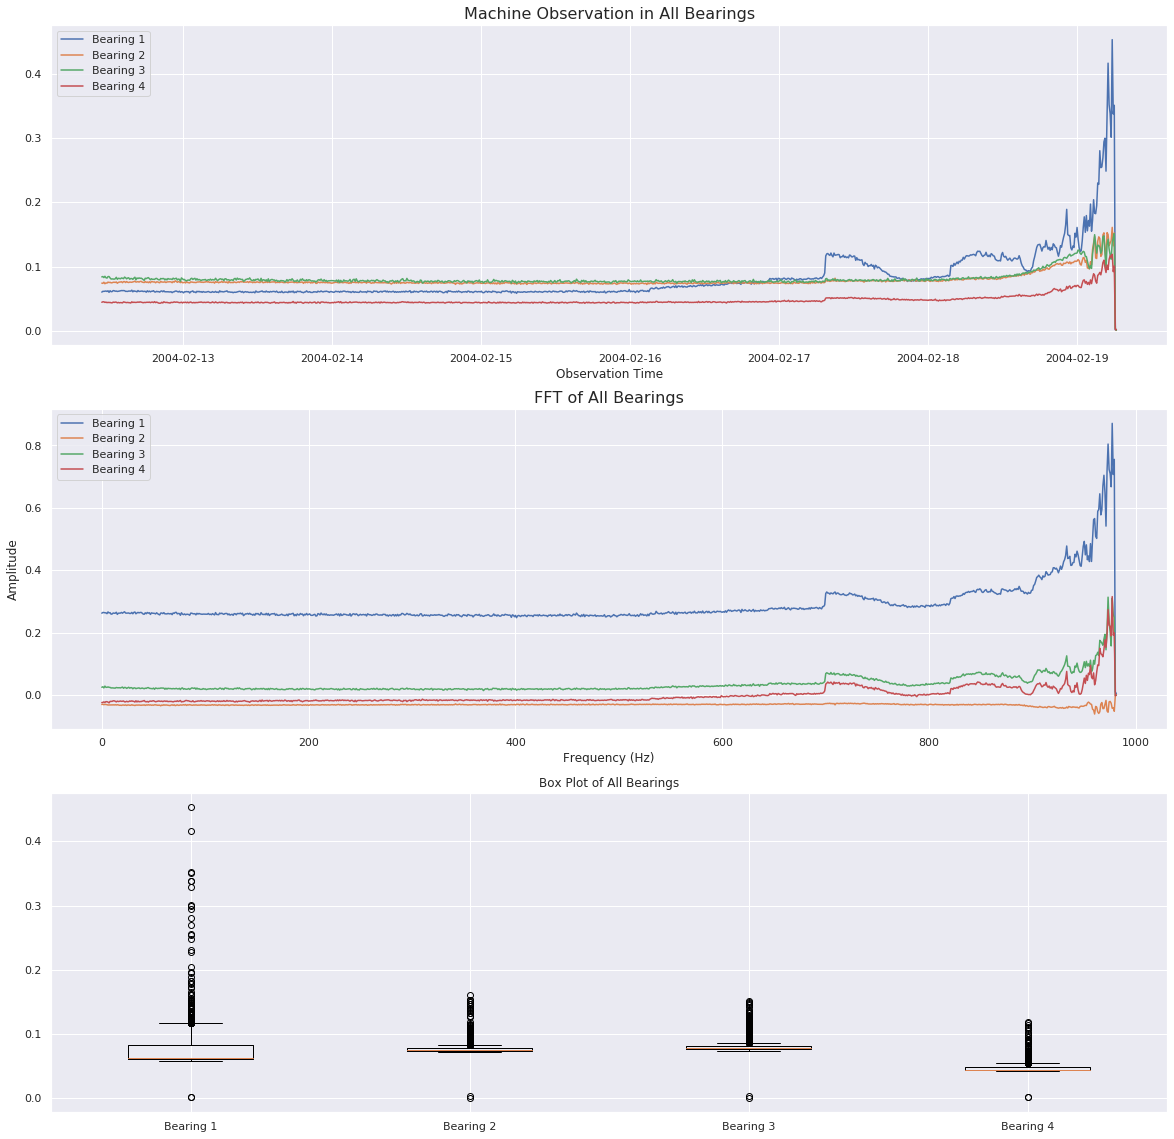

In [33]:
# Plot the data
def plot_series(series, ax):
    ax.plot(df.loc[:, series.name], label=series.name)
    ax.legend()
    
    
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20))
# plt.figure(figsize=(20, 50))
for col in df.columns:
    plot_series(df.loc[:, col], ax1)
ax1.set_title('Machine Observation in All Bearings', fontsize=16)
ax1.set_xlabel('Observation Time')
ax2.plot(data_fft[:, 0].real, label='Bearing 1')
ax2.plot(data_fft[:, 1].imag, label='Bearing 2')
ax2.plot(data_fft[:, 2].real, label='Bearing 3')
ax2.plot(data_fft[:, 3].real, label='Bearing 4')
ax2.legend()
ax2.set_title('FFT of All Bearings', fontsize=16)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')
ax3.boxplot(df.values, labels=df.columns)
ax3.set_title('Box Plot of All Bearings')
plt.show()

### Stationarity Test
From the above figures, we know that the Bearing 1 has the highest variance and the anomaly probably start on 2004-02-17. The next step is checking the stationary of the data. Here we will use Augmented Dicky-Fuller method. We will use the package from *statsmodels* (https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

In [34]:
# Non-stationary test
def non_stationary_test(series):
    test = sm.tsa.stattools.adfuller(series)
    print('The test statistic and p-value of {0} are {1} and {2}'.format(series.name, test[0], test[1]))

for col in df.columns:
    non_stationary_test(df.loc[:, col])

The test statistic and p-value of Bearing 1 are 0.8917403027375221 and 0.9929815827688936
The test statistic and p-value of Bearing 2 are 3.2884570391043244 and 1.0
The test statistic and p-value of Bearing 3 are 1.8579416092874328 and 0.9984572689262011
The test statistic and p-value of Bearing 4 are 3.253173819560119 and 1.0


In the Augmented Dicky-Fuller test, the null hypothesis is the data is non-stationer. From the test statistic and *p*-value results, we could infer that all the bearings data are non-stationer because the *p*-value is close to significant. 

## Auto-encoder LSTM Model 

### Generate training and test datasets

When using the auto-encoder LSTM to detect anomaly, the training data comes from a range of data at normal condition. After carefully look at the previous plot, we divide the data before 15<sup>th</sup> February 2004 12:00:00 as training data and after 15<sup>th</sup> February 2004 12:00:00 as test data. 

In [35]:
df_train = df[df.index <= '2004-02-15 12:00:00']
df_test = df[df.index > '2004-02-15 12:00:00']

Text(0.5, 1.0, 'Test Data')

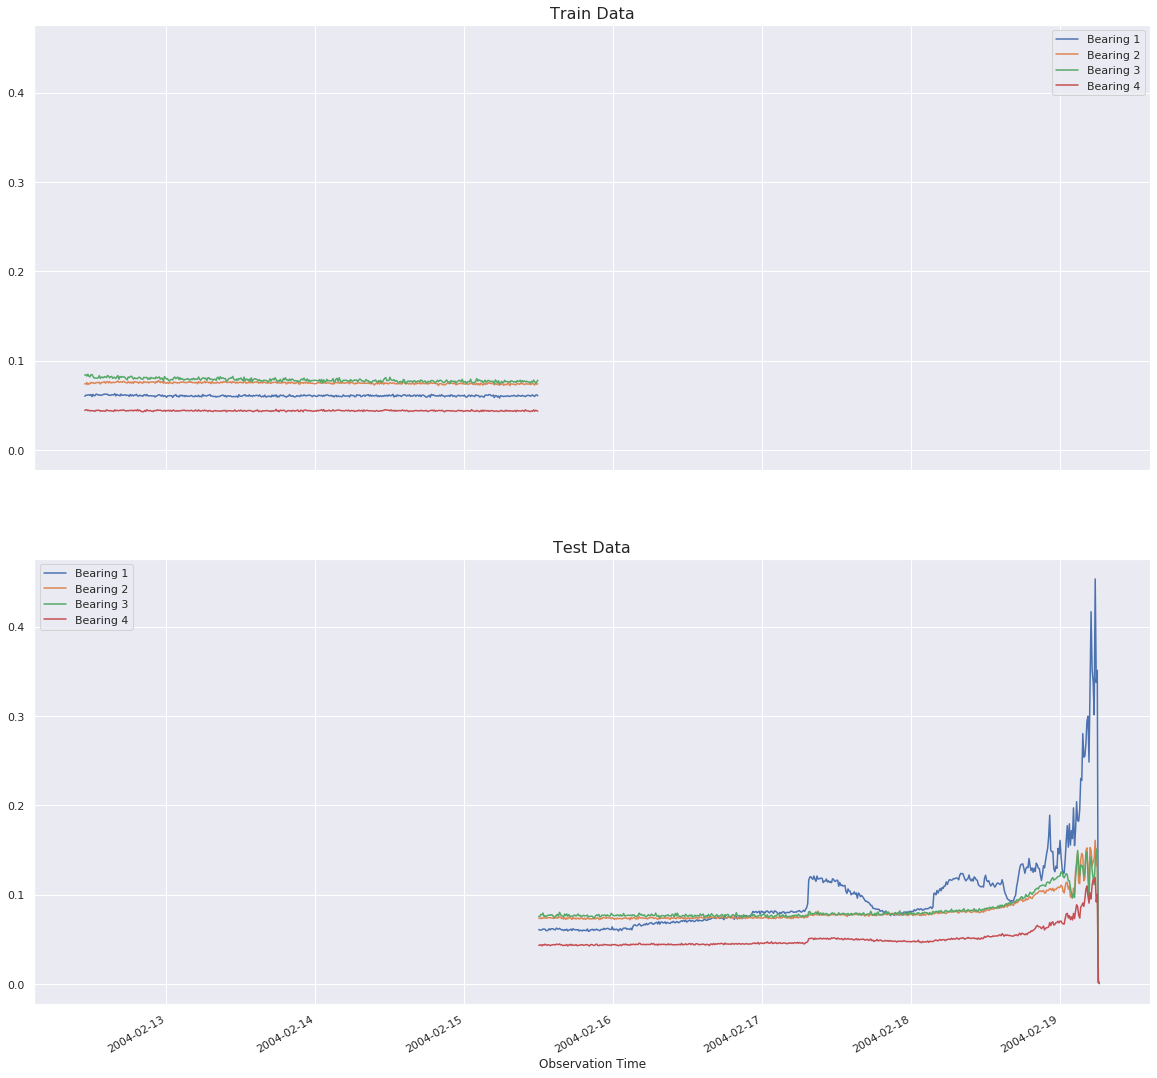

In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True, sharey=True)
df_train.plot(ax=ax1)
ax1.set_title('Train Data', fontsize=16)
df_test.plot(ax=ax2)
ax2.set_title('Test Data', fontsize=16)

Since we will be using Tensorflow, we need to preprocess the data. The LSTM model receives input with shape (n_samples, time_steps, n_features), which is in 3D format. We have to reshape the 2D data to 3D data. In LSTM, time_steps or look back is the process of looking back to several number of steps to predict. 

In [37]:
def create_dataset(X, y, time_steps=1):
    '''
    Generating data as the input to the LSTM model. 
    
    Parameters:
        X (DataFrame): The input in the 2-D shape.
        y (DataFrame): The input label in the 2-D format.
        time_steps (int): Time steps/look back. The number of steps to look back when dealing with LSTM. 
    
    Returns:
        X_output (Numpy Array): The output in the 3-D shape
        y_output (Numpy Array): The output label in the 3-D shape. 
    '''
    X_output = []
    y_output = []
    
    for i in range(len(X) - time_steps):
        t = []
        for j in range(time_steps):
            t.append(X.iloc[i + j, :])
        X_output.append(t)
        y_output.append(y.iloc[i + time_steps, :])
    
    X_output, y_output = np.squeeze(np.array(X_output)), np.array(y_output)
    
    return  X_output, y_output

To make the data to have same scale, we will use minimum and maximum scaler. We take the minimum and maximum value of the training data then transform both of the training and test data. 

In [38]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(df_train)
X_test = scaler.transform(df_test)
X_train, y_train = create_dataset(df_train, df_train, 5)
X_test, y_test = create_dataset(df_test, df_test, 5)

### Build the model

This is a model of encoder and decoder of LSTM. I put marks of encoder and decoder parts. As a reference, you can find how to build Tensorflow's auto-encoder LSTM building though this link: https://machinelearningmastery.com/lstm-autoencoders/

In [39]:
# Auto-encoder (Encoder-Decoder) LSTM model
model = Sequential()

# Encoder 
model.add(LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.0), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(TimeDistributed(Dropout(0.1)))
model.add(LSTM(8, activation='relu', return_sequences=False))

# Decoder
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(8, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(X_train.shape[2])))

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 5, 16)             1344      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 16)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 800       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 8)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 8)              544       
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 16)             1600      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 4)             

### Train the model 

In [40]:
history = model.fit(X_train, X_train, epochs=50, batch_size=8, validation_split=0.05).history

Train on 412 samples, validate on 22 samples
Epoch 1/50
412/412 [==============================] - 12s 29ms/sample - loss: 0.0291 - val_loss: 0.0079
Epoch 2/50
412/412 [==============================] - 4s 9ms/sample - loss: 0.0050 - val_loss: 0.0028
Epoch 3/50
412/412 [==============================] - 4s 9ms/sample - loss: 0.0020 - val_loss: 0.0014
Epoch 4/50
412/412 [==============================] - 3s 8ms/sample - loss: 0.0012 - val_loss: 9.8664e-04
Epoch 5/50
412/412 [==============================] - 4s 9ms/sample - loss: 0.0010 - val_loss: 9.4379e-04
Epoch 6/50
412/412 [==============================] - 6s 15ms/sample - loss: 9.6168e-04 - val_loss: 0.0010
Epoch 7/50
412/412 [==============================] - 5s 11ms/sample - loss: 9.3116e-04 - val_loss: 9.8830e-04
Epoch 8/50
412/412 [==============================] - 3s 6ms/sample - loss: 9.3333e-04 - val_loss: 8.4114e-04
Epoch 9/50
412/412 [==============================] - 2s 6ms/sample - loss: 9.6180e-04 - val_loss: 0.0011
E

### Results

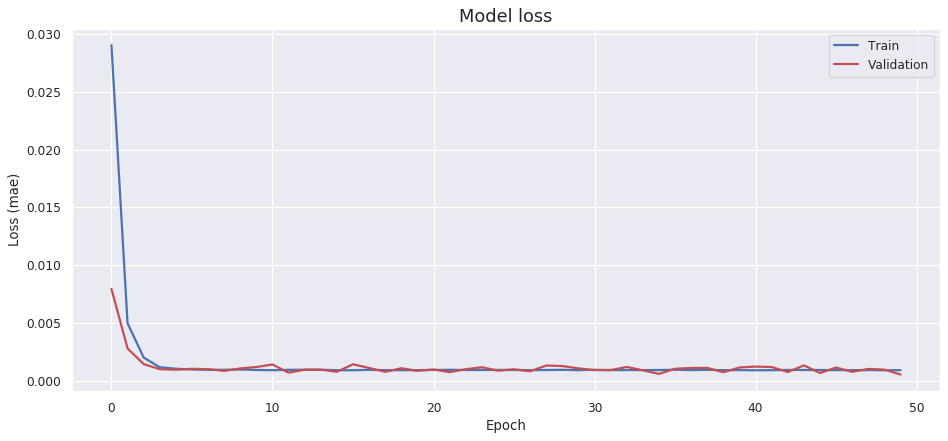

In [41]:
# Plot the loss (MAE) in each epoch
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

#### Loss (MAE) distribution 

To separate between anomalous with the normal data, we need to define a threshold. We will analyze the distribution of loss function. In our case, we calculate the loss function using the Minimum Average Error (MAE).

In [42]:
def flatten_array(X):
    '''
    Flatten a 3-D array to 2-D array.   
    
    Parameters:
    X (ndarray): Input of the data with shape (n_samples, time_steps, n_features)
    
    Returns:
    X_output (ndarray): Output of the data with shape (n_samples, n_features)
    '''
    X_output = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    
    for i in range(X.shape[0]):
        X_output[i] = X[i, (X.shape[1]-1), :]
        
    return X_output

Maximum train loss (MAE):  0.0031279512707510244


(0.0, 0.004)

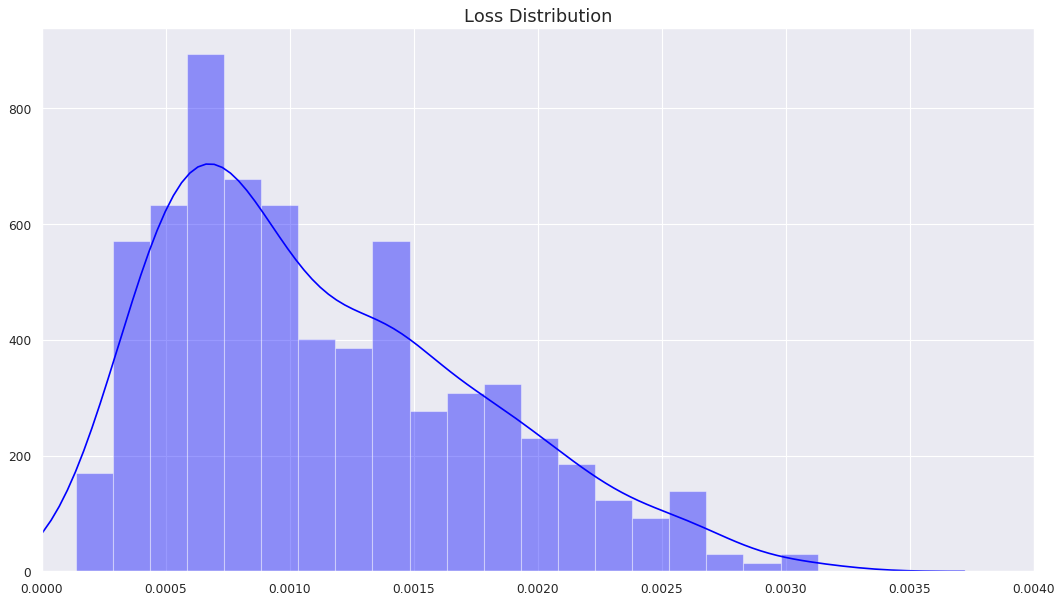

In [43]:
# Predict the training dataset
X_train_pred = model.predict(X_train)

# Calculate the loss (MAE) in the train dataset
loss_mae = np.mean(np.abs(flatten_array(X_train_pred) - flatten_array(X_train)), axis=1)
print("Maximum train loss (MAE): ", loss_mae.max())

# Plot the loss distribution
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(loss_mae, bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.004])

If we look at the above figure, we can take the threshold by observing the maximum loss function. It's around 0.00315. As we assume the training data that we train is at normal condisition, any values that greater than the threshold (0.00315), are assumed to be anomalous data. 

#### Label the model (anomaly or not)

After we define the threshold, we can separate between the anomalous and anomalous data. 

In [44]:
# Predict the training dataset
X_train_pred = model.predict(X_train)

# Calculate the loss (MAE) in the train dataset and label the data (True/False)
loss_mae = np.mean(np.abs(flatten_array(X_train_pred)-flatten_array(X_train)), axis=1)
threshold = 0.00315
result_train = pd.DataFrame({'Loss (MAE)': loss_mae, 'Threshold':threshold})
result_train['Anomaly'] = result_train['Loss (MAE)'] > result_train['Threshold']
result_train.index = df_train.iloc[5:, :].index

In [45]:
# Predict the test dataset
X_test_pred = model.predict(X_test)

# Calculate the loss (MAE) in the test dataset and label the data (True/False)
loss_mae = np.mean(np.abs(flatten_array(X_test_pred)-flatten_array(X_test)), axis=1)
threshold = 0.00315
result_test = pd.DataFrame({'Loss (MAE)': loss_mae, 'Threshold':threshold})
result_test['Anomaly'] = result_test['Loss (MAE)'] > result_test['Threshold']
result_test.index = df_test.iloc[5:, :].index

In [46]:
# Join the training and test results
result = pd.concat([result_train, result_test])
result

,Loss (MAE),Threshold,Anomaly
Observation Time,,,
2004-02-12 11:42:39,0.002287,0.00315,False
2004-02-12 11:52:39,0.001647,0.00315,False
2004-02-12 12:02:39,0.003014,0.00315,False
2004-02-12 12:12:39,0.002426,0.00315,False
2004-02-12 12:22:39,0.002402,0.00315,False
...,...,...,...
2004-02-19 05:42:39,0.103247,0.00315,True
2004-02-19 05:52:39,0.154017,0.00315,True
2004-02-19 06:02:39,0.113091,0.00315,True


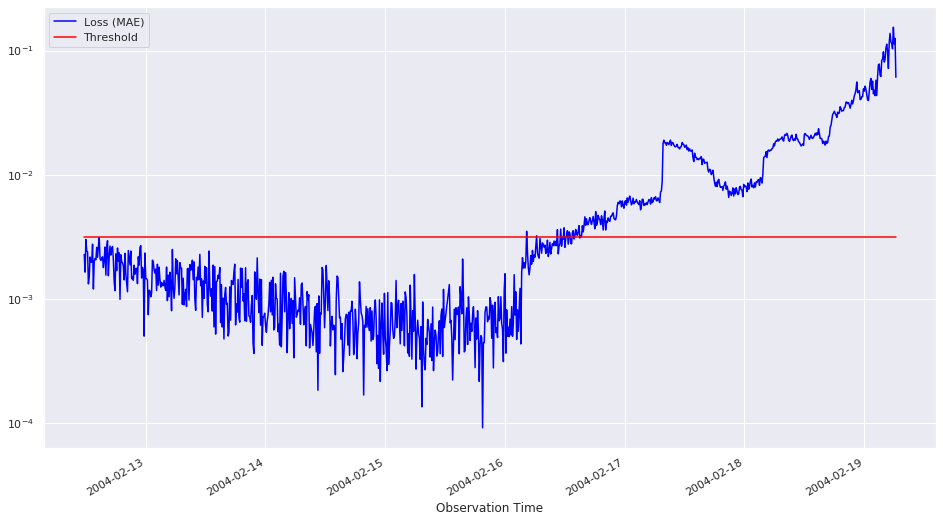

In [47]:
# Plot the separation of anomalous and non-anomalous data
result.plot(logy=True, figsize=(16,9), color=['blue','red'])

From the given data, we can see that the machine started to fail on around 16<sup>th</sup> February 2004. By using this model, we can deploy and detect for future anomalies.

#### Save the model

In [48]:
model.save('autoencoder_lstm_model.h5')